У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

### Данные

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

Итого, в качестве входных данных будут представлены:
● data_train.csv: id, vas_id, buy_time, target
● features.csv.zip: id, <feature_list>
И тестовый набор:
● data_test.csv: id, vas_id, buy_time

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы снимможновоспользоватьсяpandas.read_csv,либоможновоспользоваться библиотекой Dask.
Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(..., average=’macro’).
sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation
 
Формат представления результата
1. Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука.
3. Презентация в формате .pdf, в которой необходимо отразить:
● Информация о модели, ее параметрах, особенностях и основных результатах.
● Обоснование выбора модели и ее сравнение с альтернативами.
● Принцип составления индивидуальных предложений для выбранных
абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

In [1]:
import numpy as np
import datetime
import pandas as pd
import dask.dataframe as dd
from datetime import date
import matplotlib.pyplot as plt

Проведем предварительный анализ и обработку входных данных. 

In [2]:
TRAIN_DF_PATH = 'data_train.csv'
users_data_df_PATH = 'data_test.csv'
FEATURES_PATH = 'features.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DF_PATH)
train_df = train_df.drop('Unnamed: 0', axis=1)

In [4]:
train_df.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


In [5]:
features_df = dd.read_csv(FEATURES_PATH, sep="\t")
features_df = features_df.drop('Unnamed: 0', axis=1)

In [6]:
train_df['date'] =  train_df['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [7]:
print(f"min: {train_df['date'].min()} | max: {train_df['date'].max()}")

min: 2018-07-09 | max: 2018-12-31


In [8]:
data_nole = train_df.loc[(train_df['target']==0, 'vas_id') ].value_counts().sort_index()
data_one = train_df.loc[(train_df['target']==1, 'vas_id') ].value_counts().sort_index()

In [9]:
data_1 = {
    'vas_id':[],
    '0': [],
    '1': []
}

In [10]:
data_1['vas_id'] = (list(data_nole.index))

In [11]:
data_1['0'] = (list(data_nole.values))

In [12]:
data_1['1'] = (list(data_one.values))

In [13]:
pd.DataFrame(data_1)

,vas_id,0,1
0,1.0,304511,5664
1,2.0,244708,4797
2,4.0,63991,21765
3,5.0,92393,1692
4,6.0,33174,24704
5,7.0,15219,213
6,8.0,13003,347
7,9.0,4468,1004


In [14]:
train_df['id'].value_counts().sort_values(ascending=False)

1347260    3
17679      3
340716     3
1596002    3
1195576    3
          ..
1934276    1
4340166    1
2891727    1
66499      1
3022610    1
Name: id, Length: 806613, dtype: int64

In [15]:
features_df.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [16]:
train_df['id'].value_counts().sort_values(ascending=False)

1347260    3
17679      3
340716     3
1596002    3
1195576    3
          ..
1934276    1
4340166    1
2891727    1
66499      1
3022610    1
Name: id, Length: 806613, dtype: int64

Как можно заметить, что несколько некоторым пользователям поступало предложение несколько раз. 

Построим динамику предложений, которые делались пользователям.
Видно, что из месяца в месяц к-во предложений которое делалось пользователям по услугам с номерами 1 и 2 - уменьшалось. И, в какой-то момент 19-11-2018 к-во пользователей, которые приобрели услуги оказлалось больше чем отказавшихся. Данные по продложениям выполненным в этот день лучше не учитывать.

In [17]:
from datetime import date

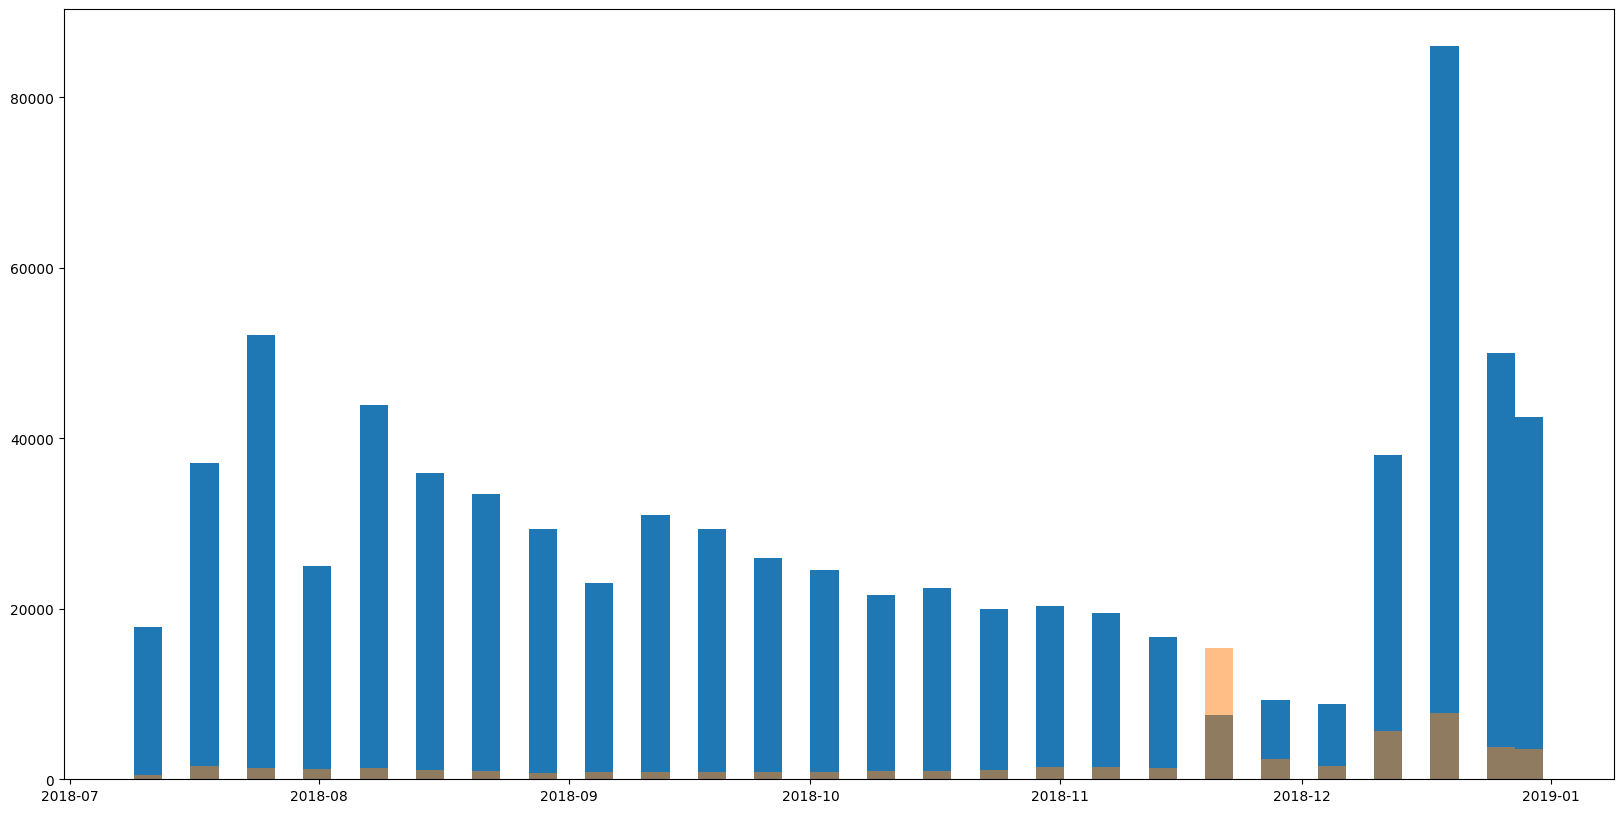

In [18]:
plt.figure(figsize=(20,10))
plt.hist(train_df.loc[(train_df['target']==0, 'date') ], bins=50, rwidth=5, stacked=False)
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.show()

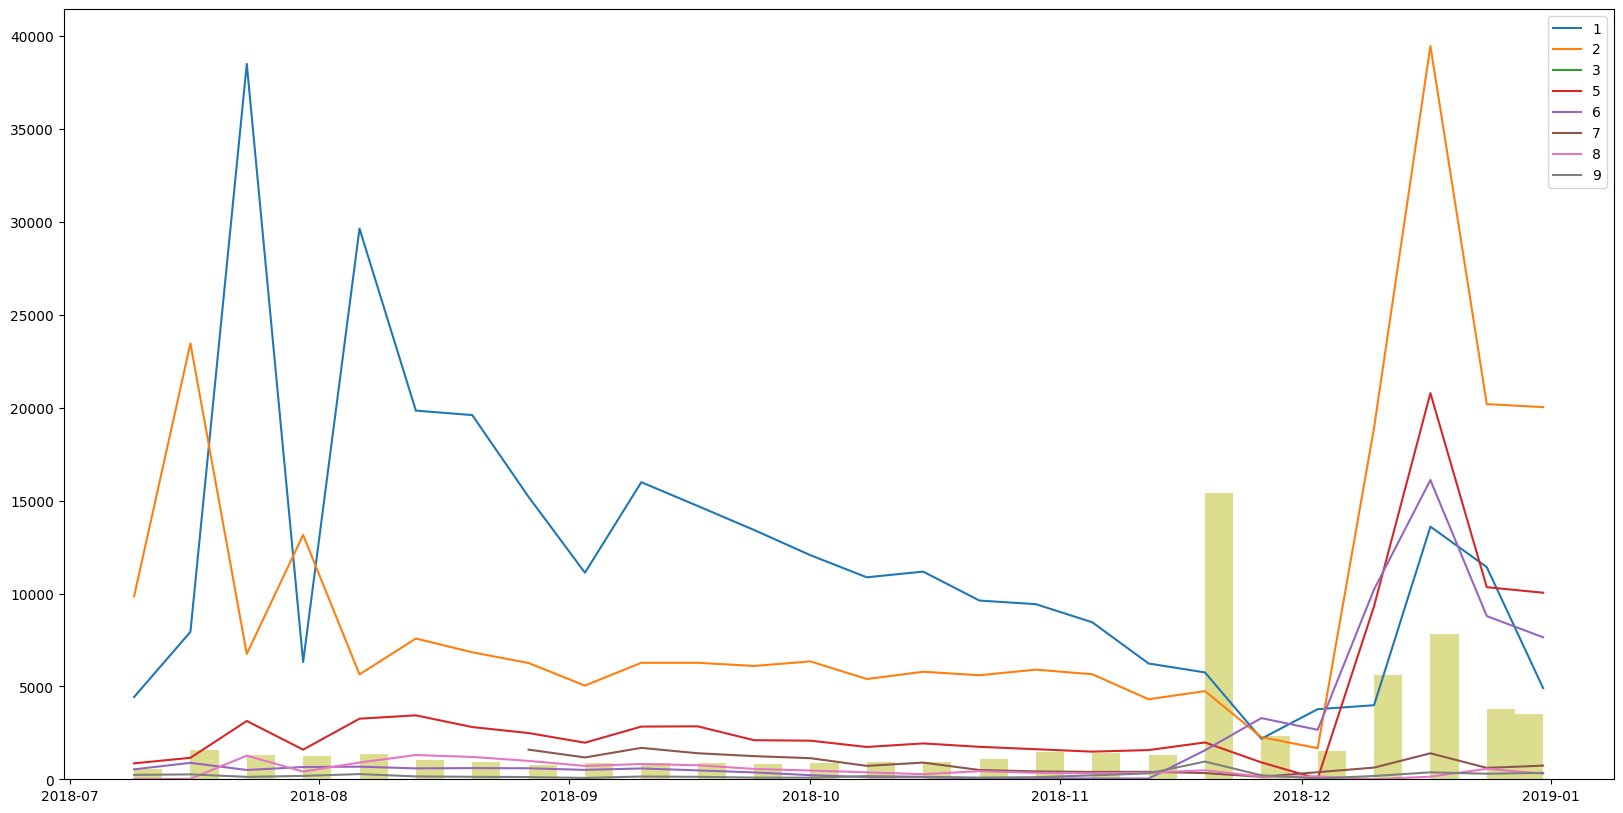

In [19]:
plt.figure(figsize=(20,10))
plt.plot(train_df.loc[(train_df['vas_id']==1.0, 'date') ].value_counts().sort_index(),label='1')
plt.plot(train_df.loc[(train_df['vas_id']==2.0, 'date') ].value_counts().sort_index(),label='2')
plt.plot(train_df.loc[(train_df['vas_id']==3.0, 'date') ].value_counts().sort_index(),label='3')
plt.plot(train_df.loc[(train_df['vas_id']==5.0, 'date') ].value_counts().sort_index(),label='5')
plt.plot(train_df.loc[(train_df['vas_id']==6.0, 'date') ].value_counts().sort_index(),label='6')
plt.plot(train_df.loc[(train_df['vas_id']==7.0, 'date') ].value_counts().sort_index(),label='7')
plt.plot(train_df.loc[(train_df['vas_id']==8.0, 'date') ].value_counts().sort_index(),label='8')
plt.plot(train_df.loc[(train_df['vas_id']==9.0, 'date') ].value_counts().sort_index(),label='9')
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.legend()
plt.show()

Видно, что к-во предлагаемых услуг 1 и 2 уменьшалось вплоть до декабря. затем последовал большой скачек. Видимо, перед новым годом компания предложила какие-то выгодные условия по тарифам.

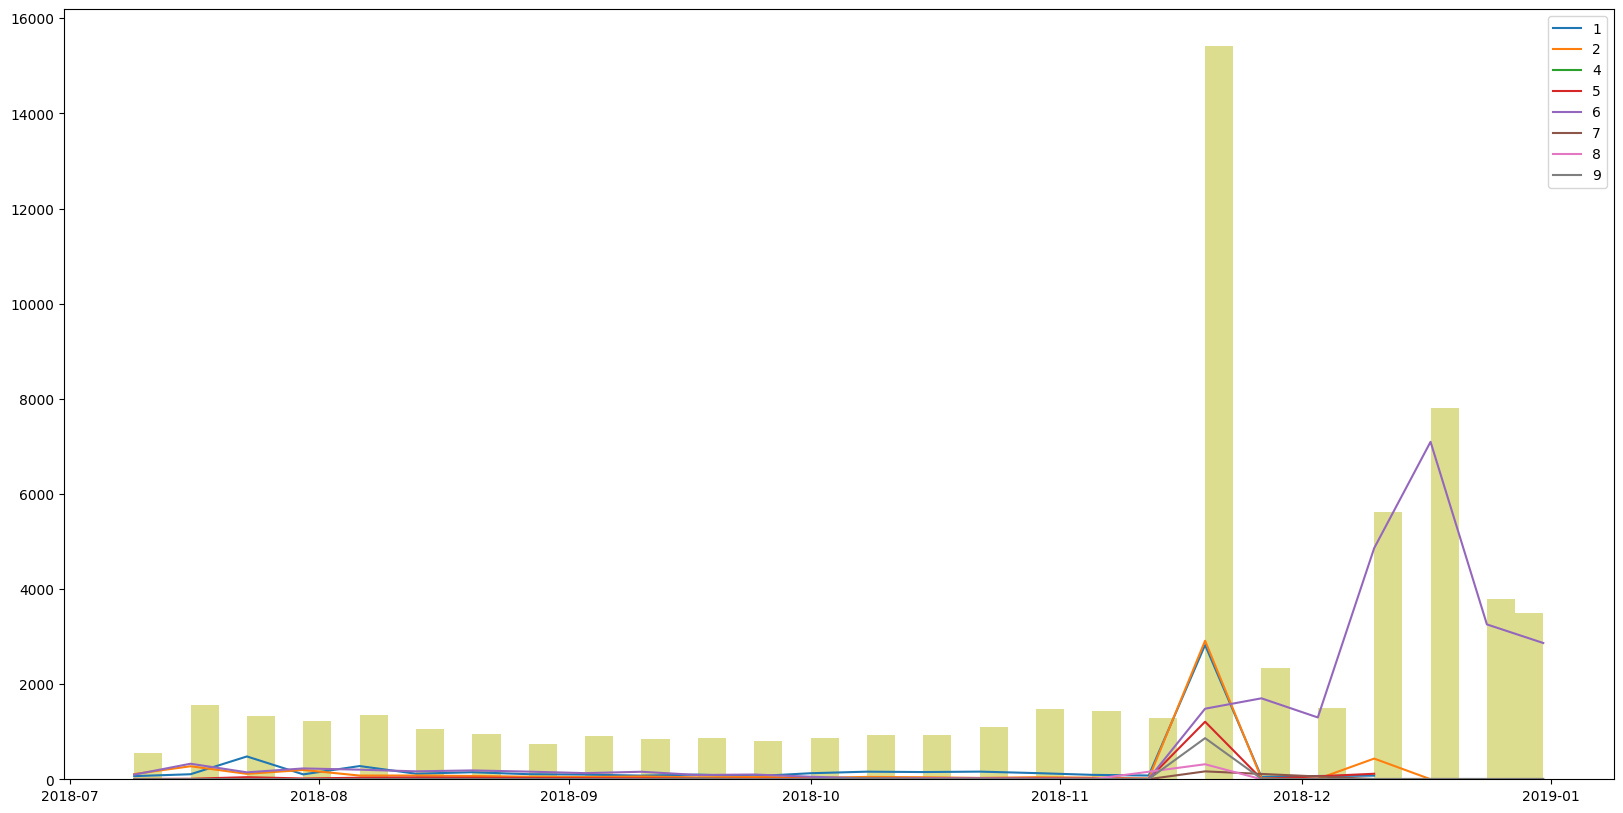

In [20]:
plt.figure(figsize=(20,10))
plt.plot(train_df.loc[((train_df['vas_id']==1.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='1')
plt.plot(train_df.loc[((train_df['vas_id']==2.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='2')
plt.plot(train_df.loc[((train_df['vas_id']==3.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='4')
plt.plot(train_df.loc[((train_df['vas_id']==5.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='5')
plt.plot(train_df.loc[((train_df['vas_id']==6.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='6')
plt.plot(train_df.loc[((train_df['vas_id']==7.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='7')
plt.plot(train_df.loc[((train_df['vas_id']==8.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='8')
plt.plot(train_df.loc[((train_df['vas_id']==9.0) & (train_df['target']==1), 'date') ].value_counts().sort_index(),label='9')
plt.hist(train_df.loc[(train_df['target']==1, 'date') ], bins=50, rwidth=5, stacked=False, alpha=0.5)
plt.legend()
plt.show()


В декабре к-во покупок услуги номер 6 практически полностью совпадет с к-вом предложений.

По к-ву подключений лидируют услуги 4 и 6.

In [21]:
train_df.loc[(train_df['target']==1, 'vas_id') ].value_counts().sort_index()

1.0     5664
2.0     4797
4.0    21765
5.0     1692
6.0    24704
7.0      213
8.0      347
9.0     1004
Name: vas_id, dtype: int64

In [22]:
dic = {'vas_id':[],
       '0':[],
       '1':[]
        }
vas_ids = np.sort(train_df['vas_id'].unique())

for vas_id in vas_ids:
    temp_df = train_df.loc[(train_df['vas_id']==vas_id)]
    c_0 = len(temp_df.loc[(temp_df['target']==0)])/len(temp_df['target'])
    c_1 = len(temp_df.loc[(temp_df['target']==1)])/len(temp_df['target'])
    dic['vas_id'].append(vas_id)
    dic['0'].append(f'{c_0:.3f}')
    dic['1'].append(f'{c_1:.3f}')
pd.DataFrame(dic)

,vas_id,0,1
0,1.0,0.982,0.018
1,2.0,0.981,0.019
2,4.0,0.746,0.254
3,5.0,0.982,0.018
4,6.0,0.573,0.427
5,7.0,0.986,0.014
6,8.0,0.974,0.026
7,9.0,0.817,0.183


Удалим из train_df все данные за 2018-11-19.

In [23]:
train_df=train_df[train_df['buy_time'] != int(datetime.datetime(2018,11,19,1,0).timestamp())]

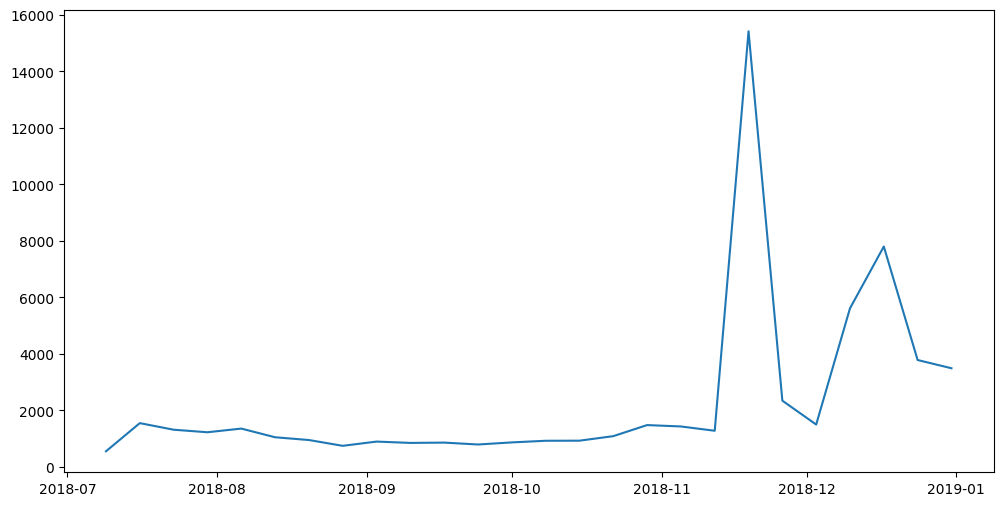

In [24]:
plt.figure(figsize=(12,6))
plt.plot(train_df.loc[(train_df['target']==1, 'date') ].value_counts().sort_index())

Отсеим из features_df записи по пользователям, которых нет в train_df.

In [25]:
user_ids = train_df['id'].unique()
features_df = features_df.compute()

features_df = features_df.loc[(features_df['id'].isin(user_ids))]

Выполним объединение таблиц по id пользователей.
Учитываем тот факт, в таблице features_df должна иметься запись о пользователе с датой меньше либо равной записи в таблице train_df.

In [26]:
train_df = train_df.sort_index()
train_df = train_df.sort_values(by="buy_time")
features_df = features_df.sort_values(by="buy_time")


In [27]:
data_train = pd.merge_asof(train_df, features_df, on='buy_time', by='id')

Добавим новые столбцы в теблицу (День, месяц и номер недели).

In [28]:
data_train['week_on_month'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day//7)
data_train['day'] = data_train['date'].apply(lambda x: pd.to_datetime(x).day)
data_train['month'] = data_train['date'].apply(lambda x: pd.to_datetime(x).month)
# data_train['year'] = data_train['date'].apply(lambda x: pd.to_datetime(x).year)
data_train = data_train.drop('date', axis=1)
data_train = data_train.drop('buy_time', axis=1)

In [29]:
features_df.loc[(features_df['id']==1510201)]

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
1098,1510201,1541970000,349.350029,1289.570888,377.779214,1524.253202,372.361754,1503.14821,365.26382,316.273903,...,657.626154,962.229208,111.003731,199.369552,-156.747724,-6.832889,13.305572,-12.175933,-0.45614,0.0


In [30]:
train_df.loc[(train_df['id']==1510201)]

,id,vas_id,buy_time,target,date
449997,1510201,6.0,1544389200,1.0,2018-12-10
449996,1510201,4.0,1544994000,0.0,2018-12-17
449998,1510201,6.0,1544994000,1.0,2018-12-17


In [32]:
DATA_TRAIN_FEATURES_PATH = 'data_train_features.csv'
DATA_TEST_FEATURES_PATH = 'data_test_features.csv'

In [33]:
data_train.to_csv(DATA_TRAIN_FEATURES_PATH, index=False)

Выполним все вышеописаные операции для тестовой выборки.

In [34]:
import utils

In [35]:
data_test = utils.prepare_dataset(users_data_df_PATH, FEATURES_PATH)

In [36]:
data_test.head()

,id,vas_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,week_on_month,day,month
0,2905850,5.0,326.930029,227.410888,312.989214,200.223202,307.571754,179.11821,-16.08618,-65.076097,...,-18.630448,-209.747724,-15.832889,-0.694428,-2.175933,-0.45614,0.0,1,7,1
1,31619,2.0,-96.799971,100.290888,-62.040786,250.953202,-67.458246,229.84821,-16.08618,-65.076097,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1,7,1
2,1427271,6.0,-87.299971,-368.999112,339.439214,48.733202,334.021754,27.62821,-16.08618,-65.076097,...,-37.630448,116.252276,25.167111,-0.694428,38.824067,-0.45614,0.0,1,7,1
3,2162521,6.0,-96.799971,-20.459112,-110.740786,-34.936798,-116.158246,-56.04179,-16.08618,-65.076097,...,-37.630448,-298.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0,1,7,1
4,1529304,6.0,-96.799971,-394.439112,-110.740786,-447.046798,-116.158246,-468.15179,-16.08618,-54.636097,...,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0,1,7,1


In [37]:
data_test.to_csv(DATA_TEST_FEATURES_PATH, index=False)